In [556]:
%matplotlib inline

from sklearn import datasets
import copy
import random
import math

In [557]:
class LDA(object):
    """"Linear discriminant analysis for multiclass/binary classification (x(i), y(i))"""
    def __init__(self, x, y):
        #self.funcs_ = funcs_
        #verify the dimensions
        
        self.groups = {}
            
        if self.verify_dimensions(x):
            if len(x) == len(y):
                self.len_all = len(x)
                self.dmean_ = self.mean_nm(x, axis=0)
                self.std_ = self.std_nm(x, axis=0)
                self.x = x
                self.y = y
                self.separate_sets()
            else:
                sys.exit()
        else:
            print ('data dimensions are inaccurate..exiting..')
            sys.exit()
            
    def mean_(self, x):
        return float(sum(x))/len(x)
    
    #standard deviation of an array
    def std_(self, x):
        m_x = self.mean_(x)
        return math.sqrt(sum([math.pow((a-m_x), 2) for a in x])/len(x))
    
    def std_nm(self, x, axis=False):
        if axis == 0:
            return map(self.std_, zip(*x))
        elif axis == 1:
            return map(self.std_, x)
        elif not axis:
            return self.std_(self.flatten(x, []))
        else:
            return False
        
    def mean_nm(self, x, axis=False):
        
        if axis == 0:
            return map(self.mean_, zip(*x))
        elif axis == 1:
            return map(self.mean_, x)
        elif not axis:
            return self.mean_(self.flatten(x, []))
        else:
            return False
        
    def verify_dimensions(self, x):
        random_pick = len(x[random.randint(0,len(x)-1)])
        
        if sum(map(len, x))/len(x) != random_pick:
            return False
        else:
            return True
    
    def inv_(self, x):
        #print(x)
        return map(list, np.linalg.inv(x))
    
    def prod_2(self, ui, cvg):
        r = []
         
        for i, a in enumerate(ui): 
            r.append(self.dot(ui, cvg[i]))
        return r
    
    def dot(self, x, y):
        return sum(a*b for a,b in zip(x, y))
    
    #--gets the covariance matrix for a dataset/group (t(x).x/len(x))
    def get_cov_matrix(self, matrix):
        cov_mat = []
        for i in zip(*matrix): 
            l = []
            for e in zip(*matrix):
                l.append(self.dot(i, e)/len(matrix))
            cov_mat.append(l)
        return cov_mat

    #--multiplies the length of dataset with each element of vector and
    #--and divides by the total lenght of the dataset.
    def scalar_mult(self, scalar, vector, divisor):
        new_vector = []
        for  i, a in enumerate(vector):
            new_vector.append((scalar*vector[i])/divisor)
        return new_vector

    #--adds two vectors linearly
    def sum_vectors(self, a, b):
        return [g+h for g,h in zip(a,b)]

    #--calculates the global covariance matrix
    def get_global_cov(self, cov_matrices):
        temp_cov = []
        global_cov = []
        
        
        for i, a in enumerate(cov_matrices):
            l = []
            for e, j in enumerate(cov_matrices[a]):
                l.append(self.scalar_mult(self.lens[a], cov_matrices[a][e], self.len_all))
            temp_cov.append(l)
            
        for a,b in zip(*temp_cov):
            global_cov.append(self.sum_vectors(a,b))
        
        return global_cov
    
       #--substracts global mean from the group point
    def substract_mean(self, group_point):
         
        #print('mean : ', self.mean_global)
        #print('group: ', group_point)
        for i, a in enumerate(group_point): 
            #print(i, len(group_point))
            group_point[i] = group_point[i] - self.mean_global[i]
        
        return group_point
    
    
         
    #--separating the datasets based on their associated classes or labels
    def separate_sets(self):
       
        
        # 클래스 추출
        self.group_names = list(set(self.y))
  
        # 이진 분류만 가능
        if len(self.group_names) > 2:
            print ('more than two classes provided...exiting')
            sys.exit()
            
        
        # 그룹 나누기 위해 정렬
        combined  = sorted(zip(self.x, self.y), key = lambda n: n[1])
         
        # 클래스데이터 나누기
        for val,key in combined:
            if key in self.groups:
                self.groups[key].append(val)
            else:
                self.groups[key] = []
                self.groups[key].append(val)
        
         
        self.train()
        
        
    #--processes the groups
    #--finds mean for each of the data group and mean corrects it by substracting
    #--global mean out of it and then finds covariance matrices for them.
    def train(self):
        self.mean_sets = {}
        covariance_sets = {}
        self.lens ={}
        self.probability_vector = {}
        
        # 전체 데이터 평균
        self.mean_global = list(self.mean_nm(self.x, axis=0))
          
         
        for k, v in self.groups.items():
            # 클래스에 해당하는 데이터 개수 파악
            self.lens[k] = len(self.groups[k])
            # 전체 데이터에서 k클래스 비율 
            self.probability_vector[k] = self.lens[k]/self.len_all
            
            # k클래스의 데이터 평균 구하기
            self.mean_sets[k] = list(self.mean_nm(self.groups[k], axis=0))
             
            # 그룹 데이터 
            res = []
            for group in self.groups[k]:
                r = self.substract_mean(group)
                res.append(r)
            self.groups[k] = res 
            
            #공분산행렬 구하기
            covariance_sets[k] = self.get_cov_matrix(self.groups[k]) 
            
        #print('mean : ', self.mean_sets)
        #print(covariance_sets)
        self.covariance_global = self.get_global_cov(covariance_sets)
        #print(self.covariance_global)
        #--inverse the global covariance matrix
        
        #print(self.covariance_global)
        self.covariance_global = list(self.inv_(self.covariance_global))
        
        #print(self.covariance_global)
        
        #training completedelf.covariance_global
    
    #prediction or discrimnant function
    def predict(self, v, key_only=False):
        predictions  = {}
         
        for a in self.group_names:  
            predictions[a] = self.dot(self.prod_2(self.mean_sets[a], self.covariance_global), v) -\
                            (self.dot(self.prod_2(self.mean_sets[a], self.covariance_global), self.mean_sets[a])*0.5)+\
                            math.log(self.probability_vector[a])
        
        #print(predictions)
        if key_only:
            return max(predictions, key=predictions.get)
        else:
            return predictions

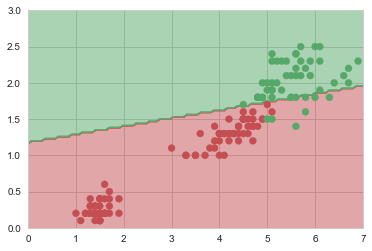

In [559]:
def test_LDA():

    iris = datasets.load_iris()
    X = iris['data'][:, (2, 3)]
    y = (iris['target']==2).astype(int)
    e = copy.deepcopy(X)
    t = LDA(X, y)
    
#     res = []
#     for a in e: 
#         r = t.predict(a)
#         #print (max(r, key=r.get)) 
#         res.append(max(r, key=r.get))
        
        
    XX, YY = np.meshgrid(np.linspace(0, 7, 100), 
                         np.linspace(0, 3, 100))
    x_new = np.c_[XX.ravel(), YY.ravel()]
    #ZZ = lda.predict(x_new).reshape(XX.shape)
    
    res = []
    for a in x_new: 
        r = t.predict(a) 
        res.append(max(r, key=r.get))

    
    ZZ = np.array(res).reshape(XX.shape)
    cmap = mpl.colors.ListedColormap(sns.color_palette(["r", "g"]).as_hex())
    plt.contourf(XX, YY, ZZ, alpha=0.5, cmap=cmap)
    plt.scatter(e[:, 0], e[:, 1], c= y, cmap=cmap) 
    
    #return res

test_LDA()

In [554]:
class multiclass_LDA(object):
    def __init__(self, x, y):
        #self.funcs_ = funcs_
        
        if self.verify_dimensions(x):
            if len(x) == len(y):
                self.x  = x
                self.y = y
                self.process_sets()
            else:
                sys.exit()
        else:
            print ('data dimensions inaccurate..exiting.')
            sys.exit()
    
    def verify_dimensions(self, x):
        random_pick = len(x[random.randint(0,len(x)-1)])
        
        if sum(map(len, x))/len(x) != random_pick:
            return False
        else:
            return True
        
        
    #returns N(N-1)/2 pairs/combinations of the classes involved.
    def get_combinations(self, unique_labels):
        g = []
        for i, a in enumerate(unique_labels):
            current_ = unique_labels[i]
            for e, b in enumerate(unique_labels):
                if e > i:
                    g.append([unique_labels[i], unique_labels[e]])
        return g

    #for separating data based on classes (not used any more)
    def separate_data(self, combined):
        #sort all the classes so that no fuss is there
        combined = sorted(combined, key=lambda n: n[1])
        for i, a in enumerate(combined):
            self.separated_features[combined[i][1]].append(combined[i][0])
            self.separated_labels[combined[i][1]].append(combined[i][1])

    #returns data based on the given binary class combination (a,b)
    def get_x(self, current_):
        result = []
        for a,b in zip(self.x, self.y):
            if b in current_:
                result.append(copy.deepcopy(a))
        return result

    #returns labels based on the given binary class combination (a, b)
    def get_y(self, current_):
        result = []
        for i, a in enumerate(self.y):
            if self.y[i] in current_:
                result.append(copy.deepcopy(self.y[i]))
        return result

    #processes each set of classifiers
    def process_sets(self):
        self.unique_labels = list(set(self.y))
        #self.separated_features = dict([(k, []) for k in self.unique_labels])
        #self.separated_labels = dict([(k, []) for k in self.unique_labels])
        #self.separate_data(zip(self.x, self.y))
        self.combinations = self.get_combinations(self.unique_labels)
        self.classifiers = {}
 
        #training a classifier for each pair
        for a in self.combinations: 
            x_ = []
            y_ = []
            current_ = a 
            x_ = self.get_x(current_)
            y_ = self.get_y(current_) 
            self.classifiers[tuple(a)] = LDA(x_,y_)

    #return predictions from each classifier
    def predict(self, v, key_only=True):
        candidates = dict([(k, 0) for k in self.unique_labels])
        t = []
         
        for key, value in self.classifiers.items(): 
            t.append(self.classifiers[key].predict(v))
             
        for a in t:
            winner_ = max(a, key=a.get)
            candidates[winner_] += 1
 
        if key_only:
            return max(candidates, key=candidates.get)
        else:
            return t

data loaded..


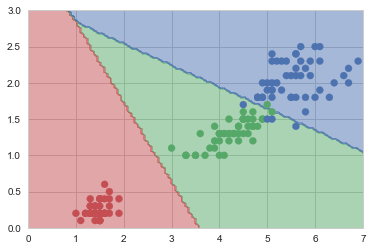

In [560]:
def test_multiclass_LDA():
    print ('data loaded..')
    iris = datasets.load_iris()
    x = iris['data'][:, (2, 3)]
    y = iris['target']
    l = copy.deepcopy(x)
    m = copy.deepcopy(y)
    t = multiclass_LDA(x, y)
    
    
    res = []
    #for a,b in zip(l, m):
        #print( t.predict(a), b)
        #res.append(t.predict(a))
     
    XX, YY = np.meshgrid(np.linspace(0, 7, 100), 
                         np.linspace(0, 3, 100))
    x_new = np.c_[XX.ravel(), YY.ravel()] 
    
    res = []
    for a in x_new:  
        res.append(t.predict(a)) 
    
    ZZ = np.array(res).reshape(XX.shape)
    cmap = mpl.colors.ListedColormap(sns.color_palette(["r", "g",'b']).as_hex())
    plt.contourf(XX, YY, ZZ, alpha=0.5, cmap=cmap)
    plt.scatter(l[:, 0], l[:, 1], c=m, cmap=cmap) 
    

test_multiclass_LDA()

In [245]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]
y = iris['target']
    
lda = LinearDiscriminantAnalysis(n_components=3, 
                                 solver="svd", store_covariance=True).fit(X, y)

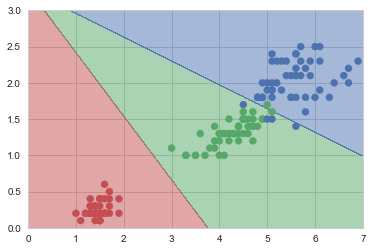

In [246]:
xmin, xmax = 0,7
ymin, ymax = 0,3
XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000), 
                     np.arange(ymin, ymax, (ymax-ymin)/1000))
ZZ = np.reshape(lda.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
cmap = mpl.colors.ListedColormap(sns.color_palette(["r", "g", "b"]).as_hex())
plt.contourf(XX, YY, ZZ, cmap=cmap, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()